# Comoparing 2 recordings
Goals
Whole recording comparisons
* Graph recordings and compare bandranges visually (psd and topo)
* See the difference between band ranges as a statistic
* see the difference between band range ratios as a statistic (delta/apha ration theta/alpha ratio ect.)
* make a correlation matrix between electrods and wavebands and waveband ratios

Epoch Comparisons
* reject epochs too flat / too high amplitude
* Graph recordings and compare bandranges visually (psd and topo)
* See the difference between band ranges as a statistic
* see teh difference between band range ratios as a statistic
* make a correlation matrix between electrods and wavebands and waveband ratios

# Whole recording comparisons

In [ ]:
# load the recordings into pandas and clean up pandas

In [1]:
import pandas as pd
import mne

In [2]:
recordingBefore = "/Users/user/projects/museExperiments/exp1_09-14-2025_1800/EEG_recording_2025-09-14-22.33.39.csv"
recordingAfter = "/Users/user/projects/museExperiments/exp1_09-14-2025_1800/EEG_recording_2025-09-14-22.53.16.csv"

In [3]:
dataframeBefore = pd.read_csv(recordingBefore)
dataframeAfter = pd.read_csv(recordingAfter)

In [4]:
# dropping RightAux since it is only needed if adding costum channels and renameing the columns to match MNE
dataframeBefore = dataframeBefore.drop(["Right AUX","timestamps"], axis=1)
dataframeAfter = dataframeAfter.drop(["Right AUX", "timestamps"], axis=1)


In [5]:
# create the dataframe

In [6]:
ch_names = list(dataframeBefore.columns) # tp9 af7 af8 tp10
ch_types = ["eeg"]*len(ch_names) # 4 eeg channels
sampling_freq = 256 # muse 2 is at 256hz
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage("standard_1020")
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: TP9, AF7, AF8, TP10
 chs: 4 EEG
 custom_ref_applied: False
 dig: 7 items (3 Cardinal, 4 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 256.0 Hz
>


In [7]:
# creating the MNE raw objects

In [8]:
rawBefore = mne.io.RawArray(dataframeBefore.values.T, info, verbose=True)  
rawAfter = mne.io.RawArray(dataframeAfter.values.T, info, verbose=True)  

Creating RawArray with float64 data, n_channels=4, n_times=35964
    Range : 0 ... 35963 =      0.000 ...   140.480 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=44952
    Range : 0 ... 44951 =      0.000 ...   175.590 secs
Ready.


In [9]:
# Doing analysis on the raw MNE object 
l_freq = 1     # Lower cutoff (Muse is not good below 1 Hz)
h_freq = 50    # Upper cutoff (for clean gamma, avoids muscle/noise)
# note the total cuttoff is 128hz but after 50hz its mostly noise/muslce artifacts
rawBefore.filter(l_freq=l_freq, h_freq=h_freq)  # In-place bandpass filter
rawAfter.filter(l_freq=l_freq, h_freq=h_freq)  # In-place bandpass filter

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 5

<RawArray | 4 x 44952 (175.6 s), ~1.4 MB, data loaded>

# Graphing PSD and topomap

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/Users/user/py-neuro-env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


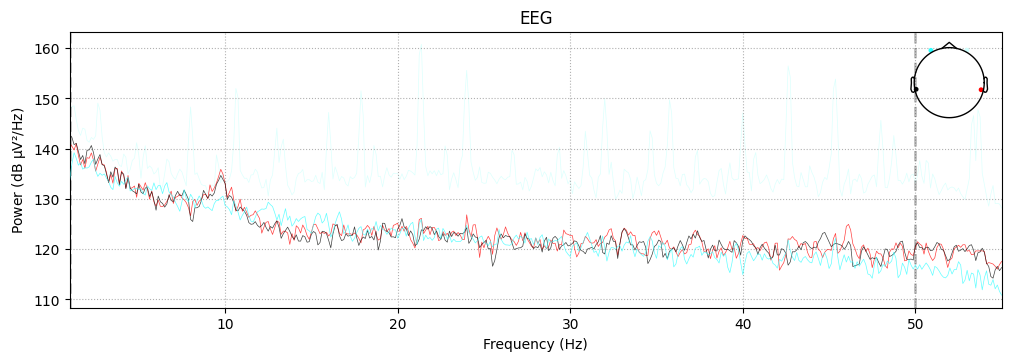

In [46]:
rawBefore.compute_psd(fmin=l_freq, fmax=h_freq+5).plot()

Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/Users/user/py-neuro-env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


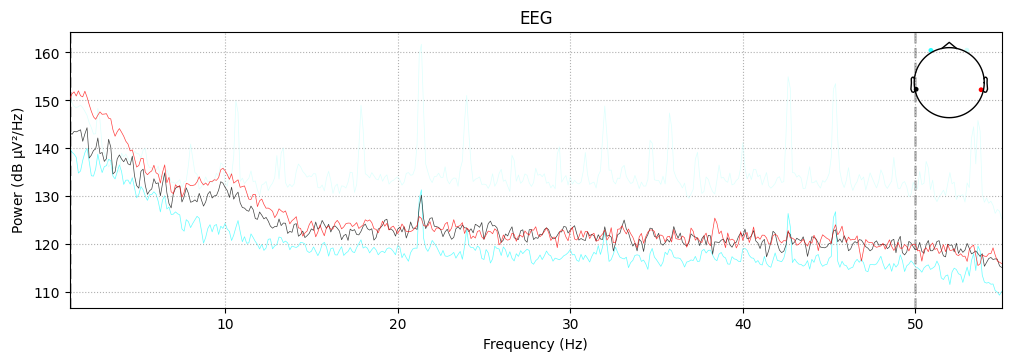

In [11]:
rawAfter.compute_psd(fmin=l_freq, fmax=h_freq+5).plot()

Effective window size : 8.000 (s)


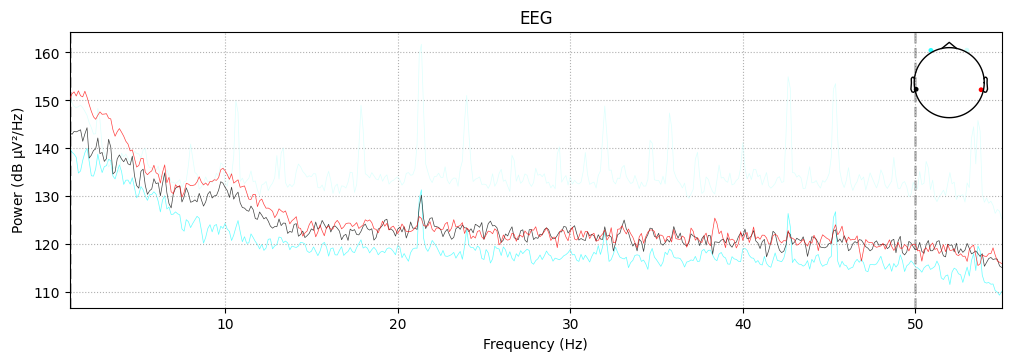

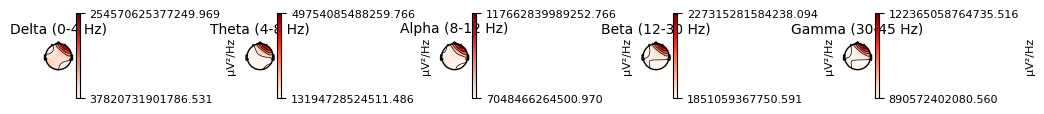

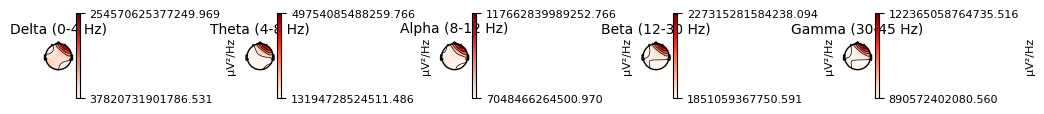

In [12]:
rawBefore.compute_psd(fmin=l_freq, fmax=h_freq+5).plot_topomap()

Effective window size : 8.000 (s)


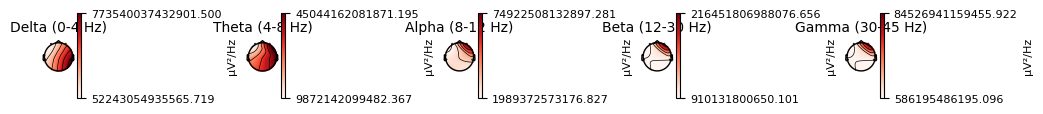

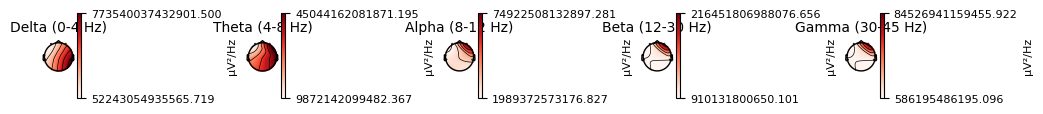

In [13]:
rawAfter.compute_psd(fmin=l_freq, fmax=h_freq+5).plot_topomap()

# Doing Epoch Analysis

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
epoch_duration = 3  # seconds
sfreq = rawBefore.info['sfreq']
n_samples = int(epoch_duration * sfreq)
data = rawBefore.get_data()  # shape (n_channels, n_samples_total)
ch_names = rawBefore.ch_names

# Split into epochs (same as in your function)
event_onsets = np.arange(0, data.shape[1] - n_samples + 1, n_samples)
ptp_epochs = []

for start in event_onsets:
    epoch = data[:, start:start + n_samples]  # shape: (n_channels, n_samples)
    # ptp = epoch.ptp(axis=1) * 1e6  # μV
    ptp = np.ptp(epoch)
    ptp_epochs.append(ptp)

ptp_epochs = np.array(ptp_epochs)  # shape: (n_epochs, n_channels)


In [85]:
plt.figure(figsize=(12, 5))
plt.boxplot(ptp_epochs.T, tick_labels=ch_names, showfliers=False)
plt.ylabel('Peak-to-peak amplitude (μV)')
plt.xlabel('Channel')
plt.title('Epoch-wise PTP Distribution per Channel')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


ValueError: Dimensions of labels and X must be compatible

In [86]:
print("ptp_epochs.T.shape:", ptp_epochs.T.shape)
print("len(ch_names):", len(ch_names))
print("First channel:", ch_names[0])
print("Last channel:", ch_names[-1])

ptp_epochs.T.shape: (46,)
len(ch_names): 4
First channel: TP9
Last channel: TP10


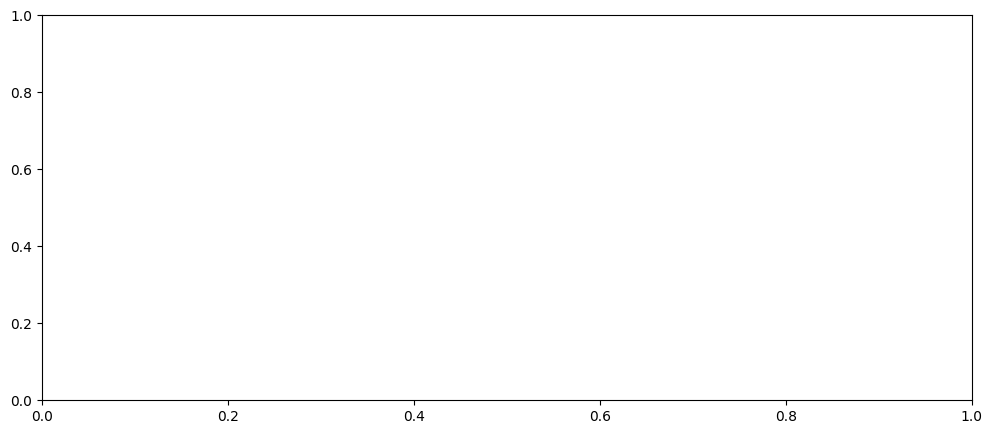

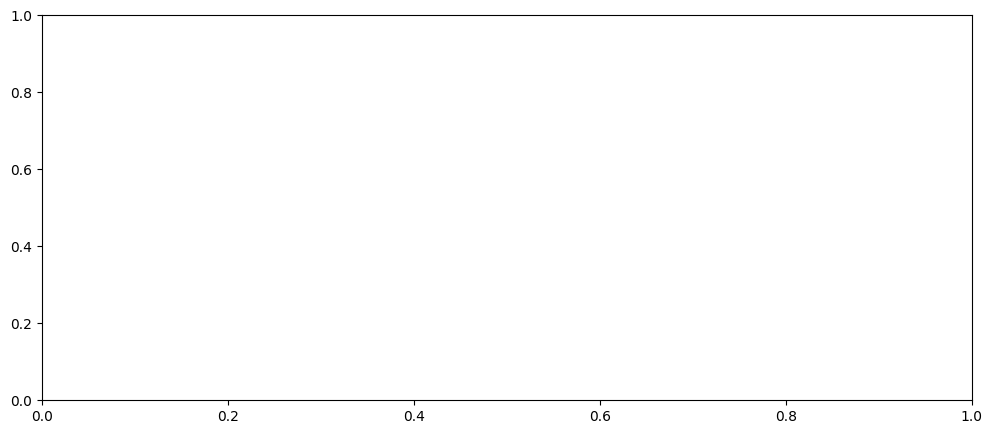

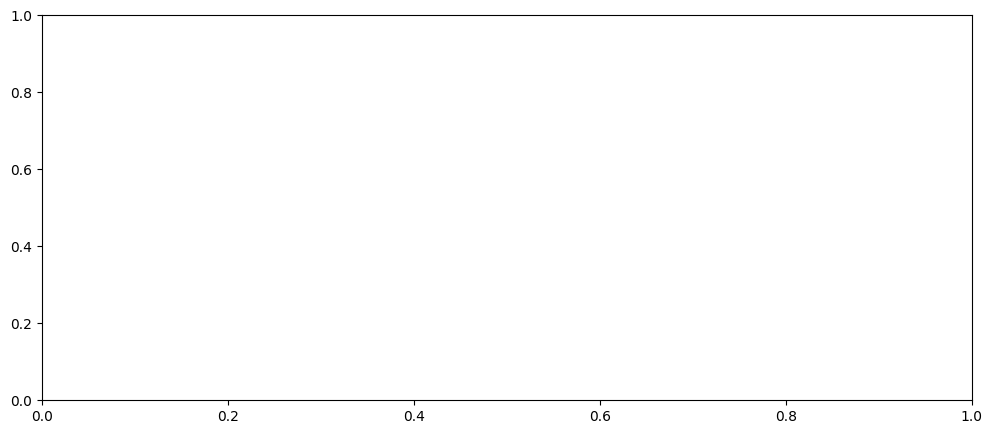

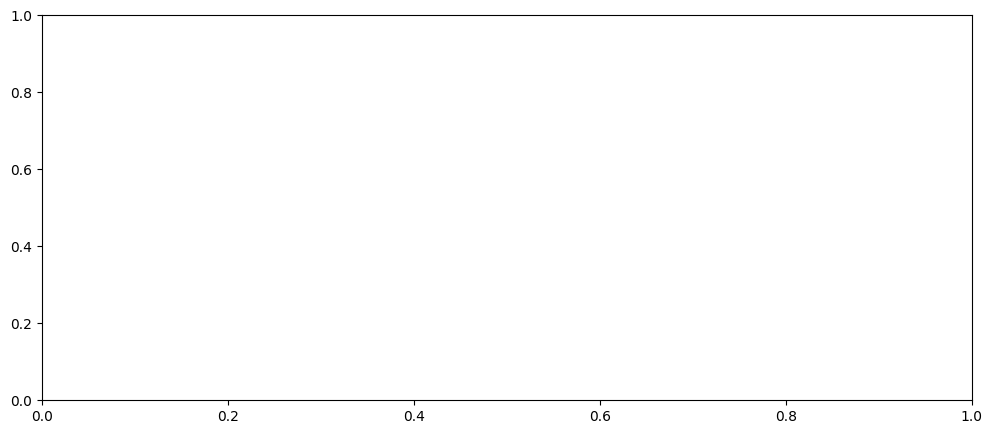

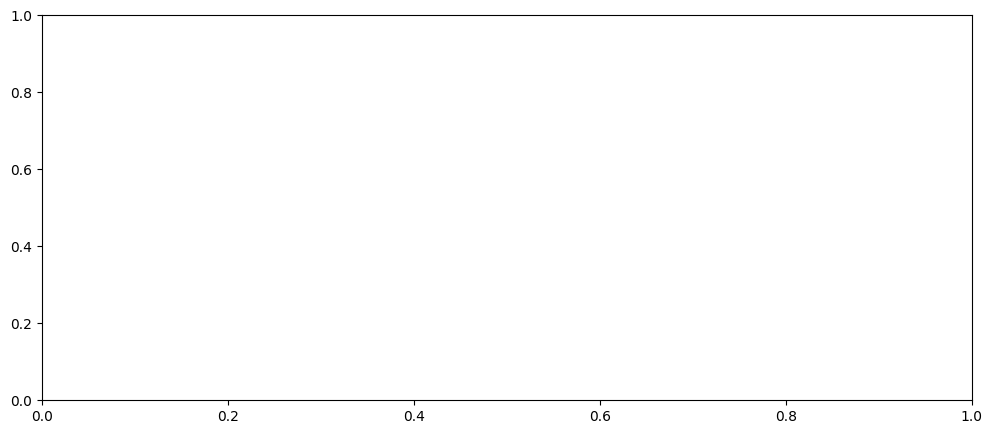

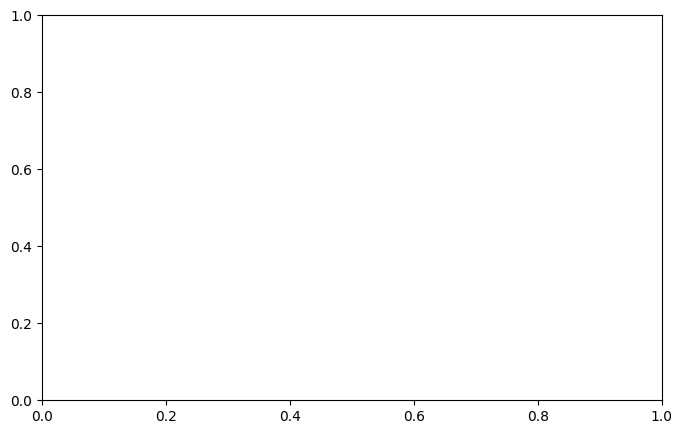

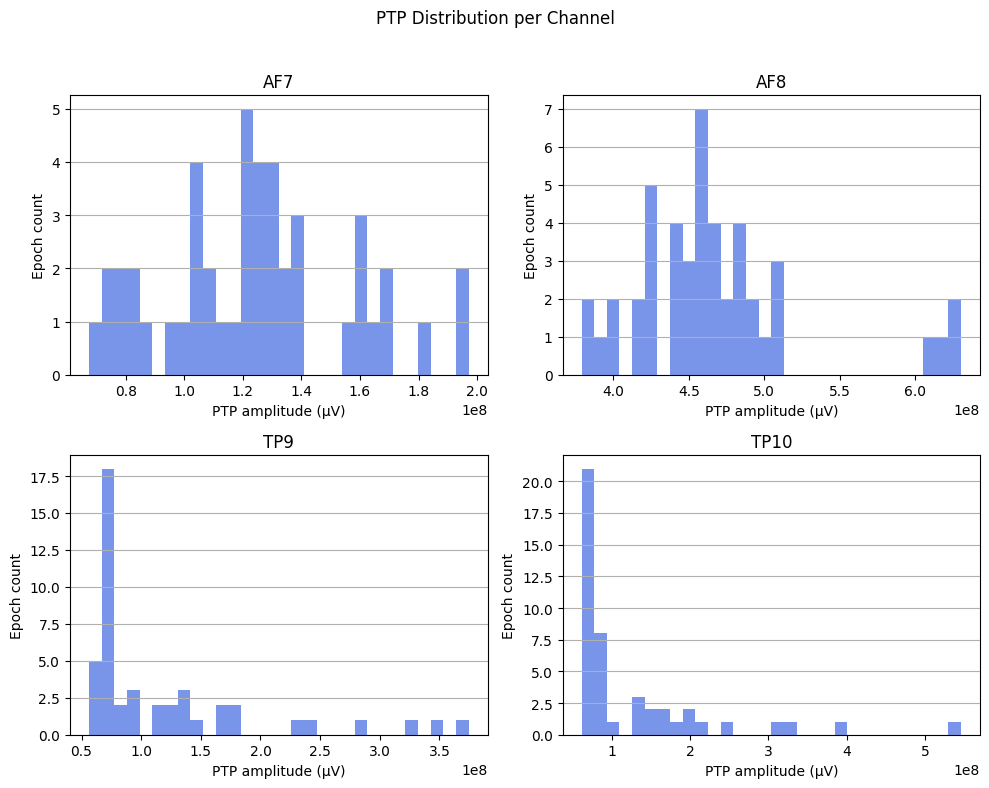

In [88]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()
for i, ch in enumerate(ch_names):
    axs[i].hist(ptp_epochs[:, i], bins=30, color='royalblue', alpha=0.7)
    axs[i].set_title(f'{ch}')
    axs[i].set_xlabel('PTP amplitude (μV)')
    axs[i].set_ylabel('Epoch count')
    axs[i].grid(axis='y')
plt.suptitle('PTP Distribution per Channel')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [94]:
import numpy as np

epoch_duration = 3  # seconds
sfreq = rawBefore.info['sfreq']
n_samples = int(epoch_duration * sfreq)

def make_epochs(
    raw,
    epoch_duration=3,
    max_ptp=None,     # Maximum allowed PTP amplitude in μV, e.g., 800
    min_ptp=None,     # Minimum allowed PTP amplitude in μV, e.g., 0.5
    event_id=1
):
    sfreq = raw.info['sfreq']
    n_samples = int(epoch_duration * sfreq)
    n_total_samples = raw.n_times

    # Calculate event onsets for non-overlapping epochs
    event_onsets = np.arange(0, n_total_samples - n_samples + 1, n_samples)
    events = np.column_stack((
        event_onsets,
        np.zeros_like(event_onsets),
        np.ones_like(event_onsets) * event_id
    ))

    # Set up rejection/flatness dicts for MNE, converting μV to V
    reject_dict = {'eeg': max_ptp * 1e-22} if max_ptp is not None else None
    flat_dict = {'eeg': min_ptp * 1e-6} if min_ptp is not None else None

    print(f"Making epochs: reject={reject_dict}, flat={flat_dict}")

    return mne.Epochs(
        raw,
        events,
        event_id=event_id,
        tmin=0,
        tmax=epoch_duration - 1/sfreq,
        baseline=None,
        preload=True,
        reject=reject_dict,
        flat=flat_dict
    )
epochsBefore = make_epochs(rawBefore)
epochsAfter = make_epochs(rawAfter)


Making epochs: reject=None, flat=None
Not setting metadata
46 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 46 events and 768 original time points ...
0 bad epochs dropped
Making epochs: reject=None, flat=None
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 58 events and 768 original time points ...
0 bad epochs dropped


In [95]:
psdBefore = rawBefore.compute_psd(fmin=l_freq, fmax=h_freq+5)
psdAfter = rawAfter.compute_psd(fmin=l_freq, fmax=h_freq+5)


Effective window size : 8.000 (s)
Effective window size : 8.000 (s)


Plotting power spectral density (dB=True).


/Users/user/py-neuro-env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


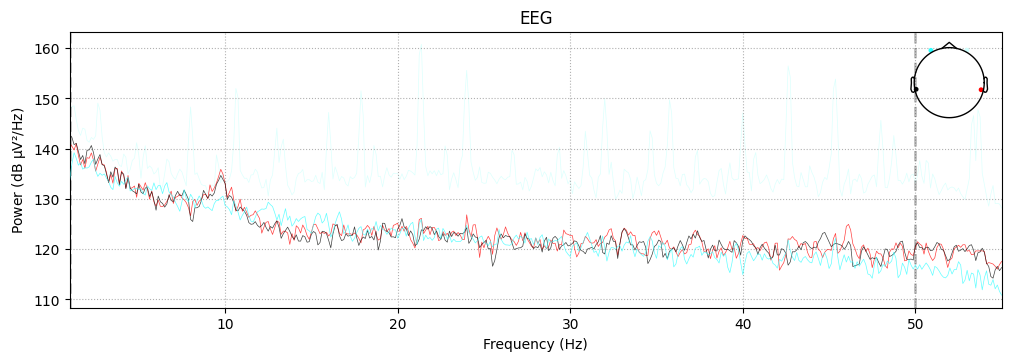

In [96]:
psdBefore.plot()

Plotting power spectral density (dB=True).


/Users/user/py-neuro-env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


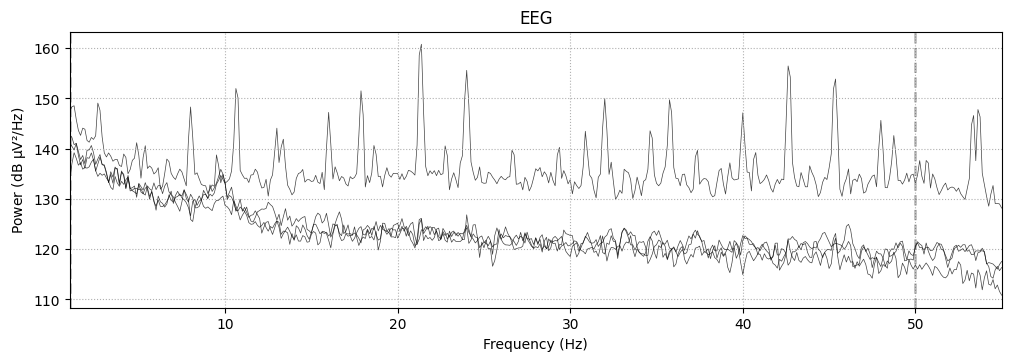

In [97]:
psdBefore.plot(spatial_colors=False)

Plotting power spectral density (dB=True).


/Users/user/py-neuro-env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


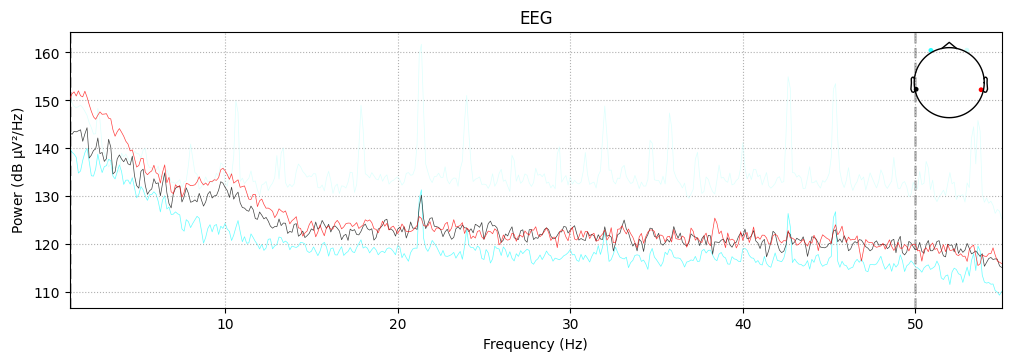

In [98]:
psdAfter.plot()

Plotting power spectral density (dB=True).


/Users/user/py-neuro-env/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


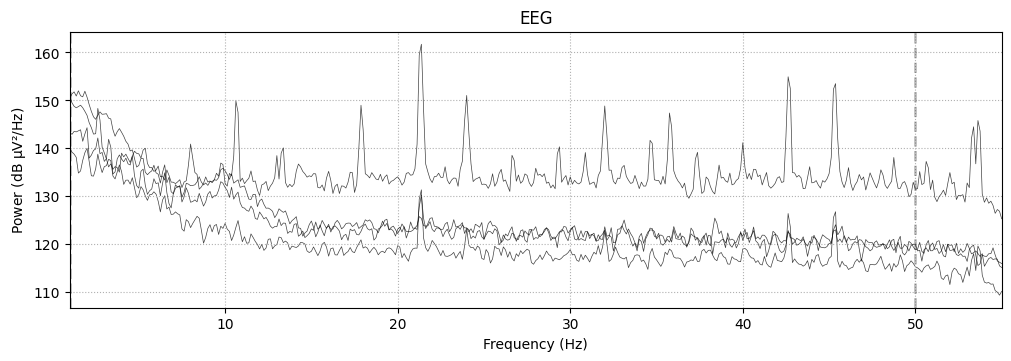

In [99]:
psdAfter.plot(spatial_colors=False)

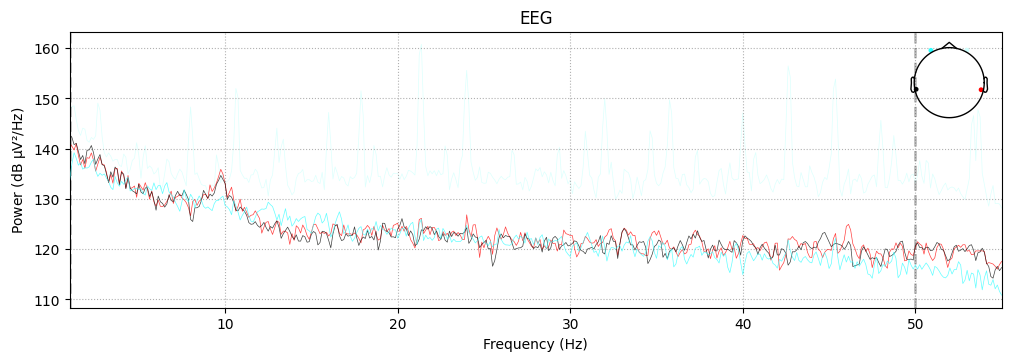

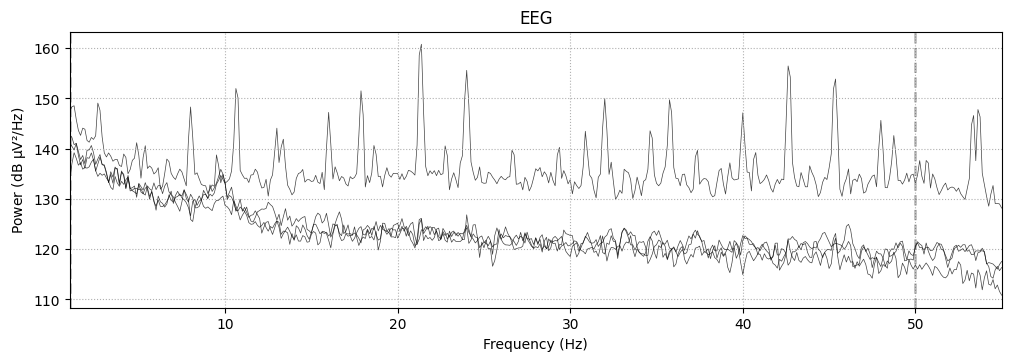

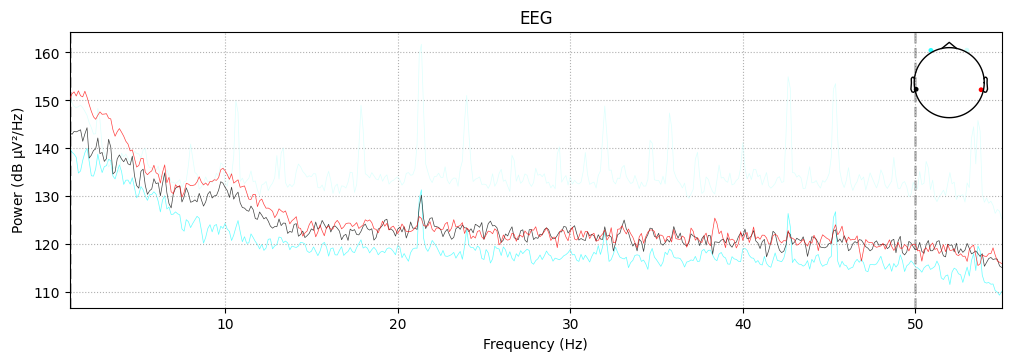

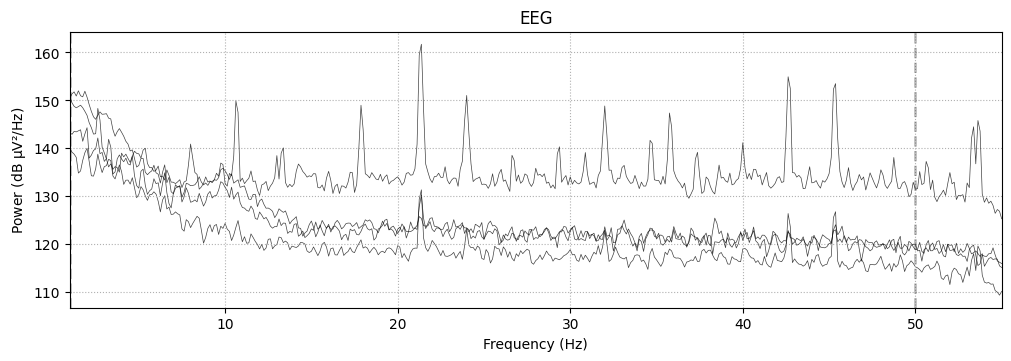

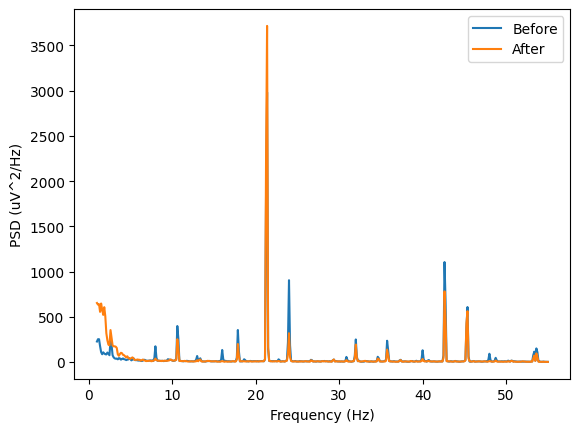

In [100]:
import matplotlib.pyplot as plt

mean_psd_before = psdBefore.get_data().mean(axis=0)  # average over channels
mean_psd_after = psdAfter.get_data().mean(axis=0)

plt.figure()
plt.plot(psdBefore.freqs, mean_psd_before, label='Before')
plt.plot(psdAfter.freqs, mean_psd_after, label='After')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (uV^2/Hz)')
plt.legend()
plt.show()


# Using MNE - features to get the features and do a deeper analysis

In [69]:
# making data using MNE-featurs

In [70]:
import mne_features
import sklearn
print(mne_features.__version__)
print(sklearn.__version__)


0.3
1.6.1


In [71]:
import numpy as np
from mne_features.feature_extraction import FeatureExtractor

rng = np.random.RandomState(42)
n_epochs, n_channels, n_times = 5, 3, 32
X = rng.randn(n_epochs, n_channels, n_times)
fe = FeatureExtractor(sfreq=100., selected_funcs=['std', 'kurtosis'])
X = fe.fit_transform(X)
print(X.shape)

(5, 6)


In [72]:
X_before = epochsBefore.get_data()
X_after  = epochsAfter.get_data()

print(X_before.shape)
print(X_after.shape)


(0, 4, 768)
(0, 4, 768)


/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/1759182101.py:1: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  X_before = epochsBefore.get_data()
/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/1759182101.py:2: RuntimeWarning: epochs._get_data() can't run because this Epochs-object is empty. You might want to check Epochs.drop_log or Epochs.plot_drop_log() to see why epochs were dropped.
  X_after  = epochsAfter.get_data()


In [73]:
features_before = fe.fit_transform(X_before)
features_after = fe.fit_transform(X_after)
print(features_before.shape)  # (n_epochs, n_features)
print(features_after.shape)

IndexError: list index out of range

In [25]:
print("Feature names:", fe.selected_funcs)

Feature names: ['pow_freq_bands', 'energy_freq_bands', 'kurtosis']


In [26]:
# Data analsyis 
feature_names = fe.selected_funcs

In [27]:
# 2nd attempt - trying to get teh column names

In [28]:
X_before = epochsBefore.get_data()  # shape: (n_epochs, n_channels, n_times)
ch_names = epochsBefore.ch_names    # e.g. ['TP9', 'AF7', 'AF8', 'TP10']

# Custom frequency bands as dict for nice labels
freq_bands = {
    'delta': [0.5, 4],
    'theta': [4, 8],
    'alpha': [8, 13],
    'beta+gamma': [13, 50]
}

In [33]:
selected_funcs = ['pow_freq_bands', 'energy_freq_bands', 'kurtosis']
from mne_features.feature_extraction import extract_features

features_before = extract_features(
    X_before,
    sfreq=epochsBefore.info['sfreq'],
    selected_funcs=selected_funcs,
    funcs_params={
        'pow_freq_bands__freq_bands': freq_bands,
        'energy_freq_bands__freq_bands': freq_bands,
    },
    ch_names=ch_names,
    return_as_df=True
)


In [34]:
print(features_before.columns)  # MultiIndex with (feature, band, channel)
# Optional: Flatten column names
features_before.columns = ['_'.join(map(str, col)) for col in features_before.columns]
print(features_before.columns.tolist())


MultiIndex([(   'pow_freq_bands',       'TP9_delta'),
            (   'pow_freq_bands',       'TP9_theta'),
            (   'pow_freq_bands',       'TP9_alpha'),
            (   'pow_freq_bands',  'TP9_beta+gamma'),
            (   'pow_freq_bands',       'AF7_delta'),
            (   'pow_freq_bands',       'AF7_theta'),
            (   'pow_freq_bands',       'AF7_alpha'),
            (   'pow_freq_bands',  'AF7_beta+gamma'),
            (   'pow_freq_bands',       'AF8_delta'),
            (   'pow_freq_bands',       'AF8_theta'),
            (   'pow_freq_bands',       'AF8_alpha'),
            (   'pow_freq_bands',  'AF8_beta+gamma'),
            (   'pow_freq_bands',      'TP10_delta'),
            (   'pow_freq_bands',      'TP10_theta'),
            (   'pow_freq_bands',      'TP10_alpha'),
            (   'pow_freq_bands', 'TP10_beta+gamma'),
            ('energy_freq_bands',       'TP9_delta'),
            ('energy_freq_bands',       'TP9_theta'),
            ('energy_freq_ba

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/2548278810.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


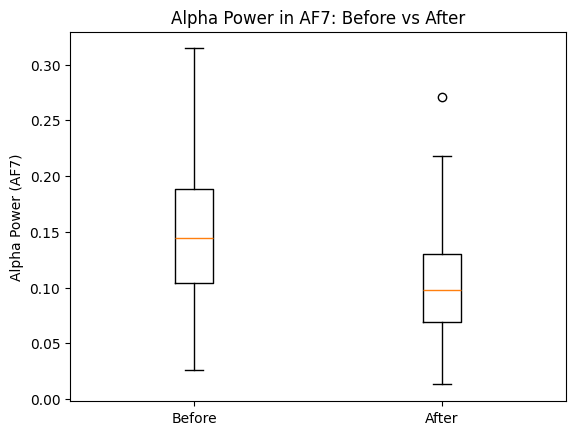

In [35]:
# Do the same for after
X_after = epochsAfter.get_data()
features_after = extract_features(
    X_after,
    sfreq=epochsAfter.info['sfreq'],
    selected_funcs=selected_funcs,
    funcs_params={
        'pow_freq_bands__freq_bands': freq_bands,
        'energy_freq_bands__freq_bands': freq_bands,
    },
    ch_names=ch_names,
    return_as_df=True
)
features_after.columns = ['_'.join(map(str, col)) for col in features_after.columns]

# Pick your feature of interest (e.g., alpha power in AF7)
col = 'pow_freq_bands_AF7_alpha'

import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])
plt.ylabel('Alpha Power (AF7)')
plt.title('Alpha Power in AF7: Before vs After')
plt.show()


/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


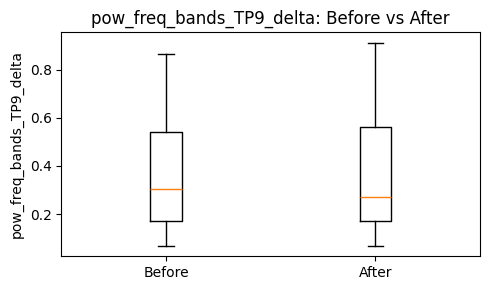

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


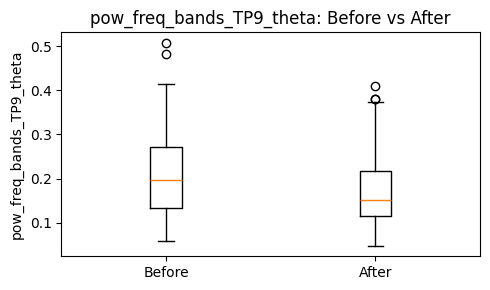

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


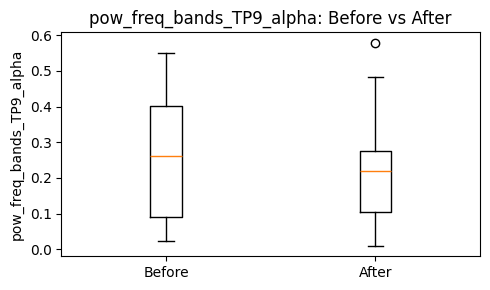

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


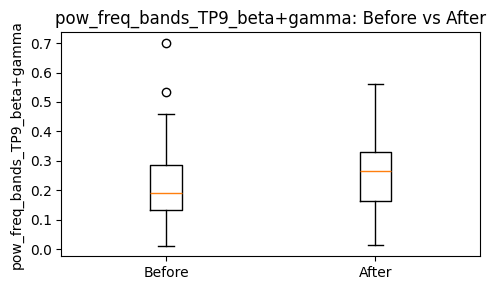

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


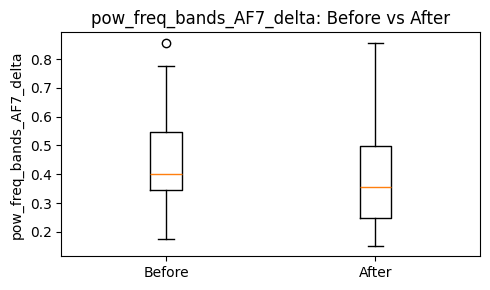

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


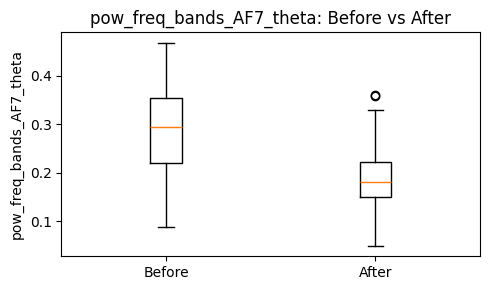

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


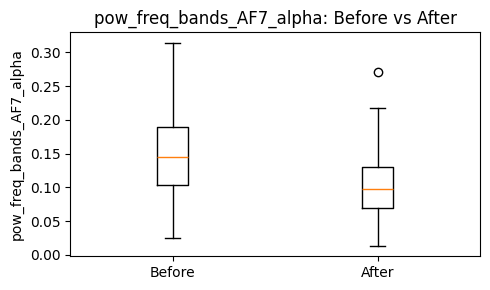

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


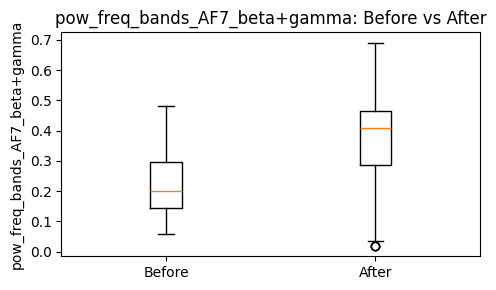

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


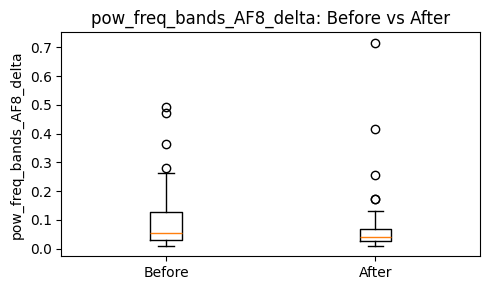

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


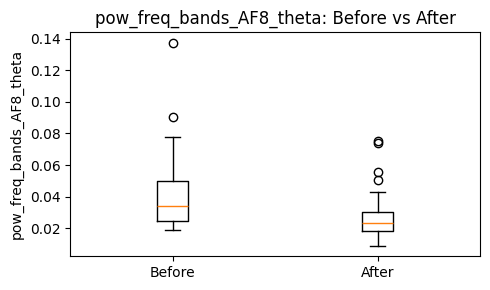

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


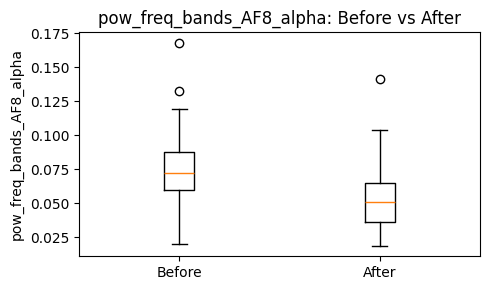

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


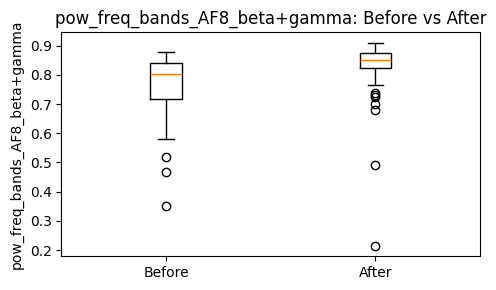

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


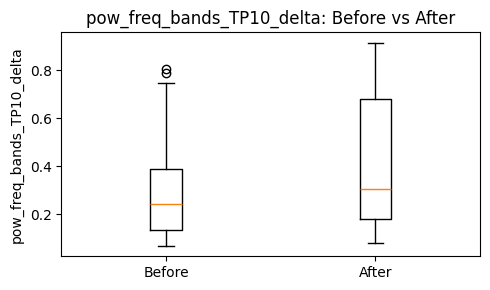

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


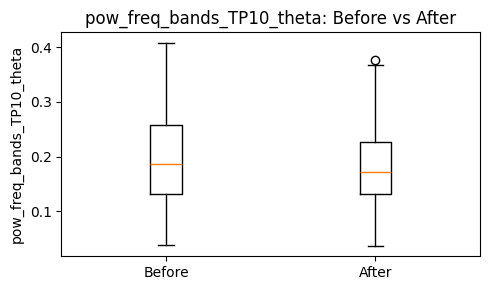

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


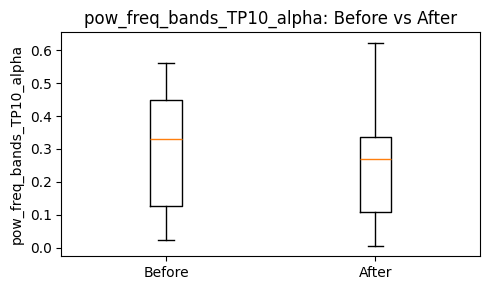

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


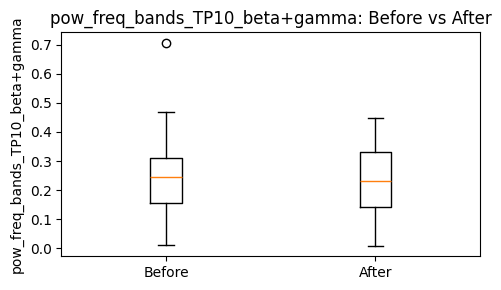

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


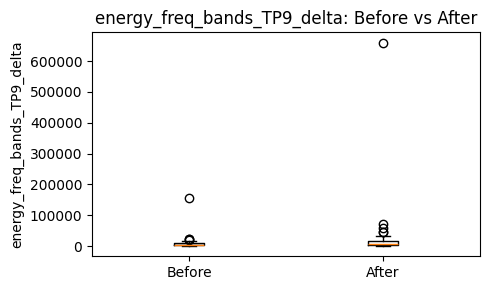

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


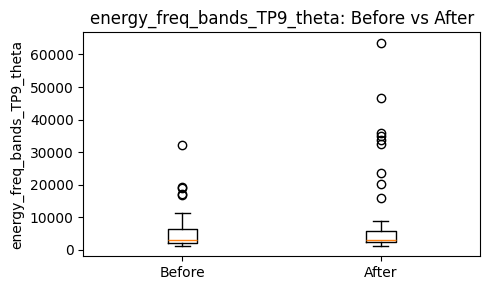

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


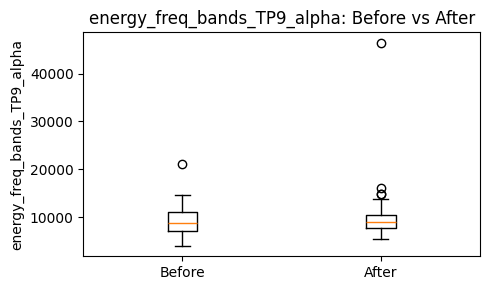

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


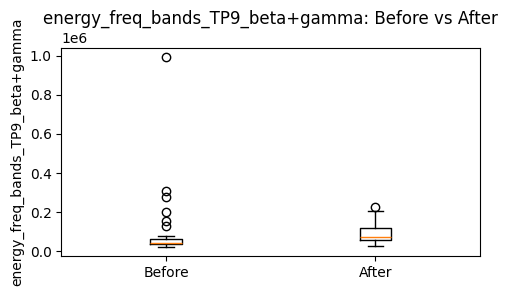

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


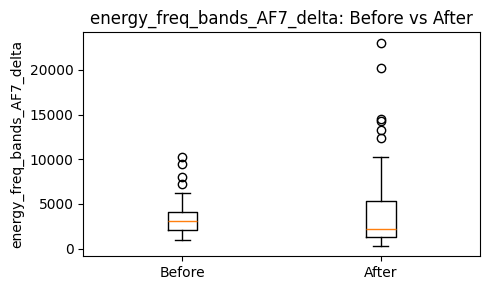

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


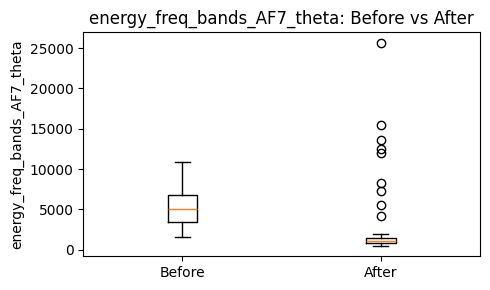

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


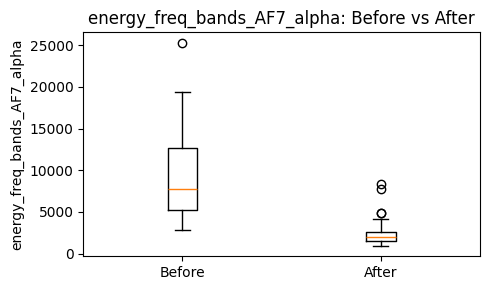

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


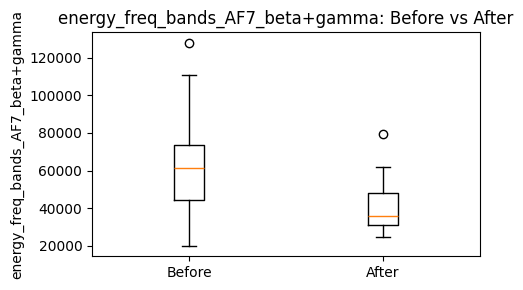

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


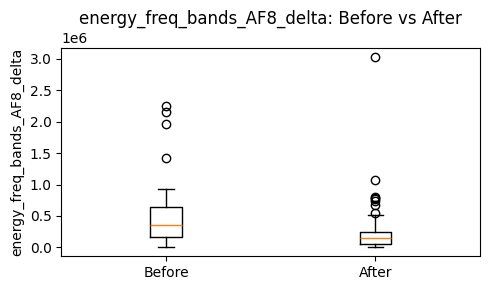

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


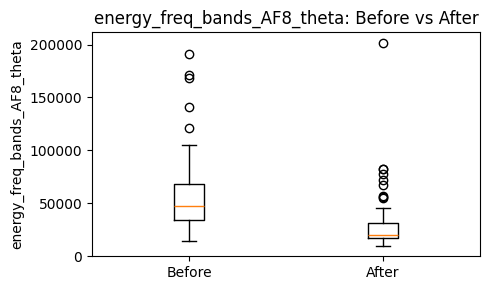

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


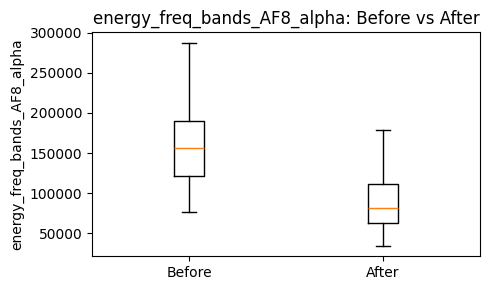

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


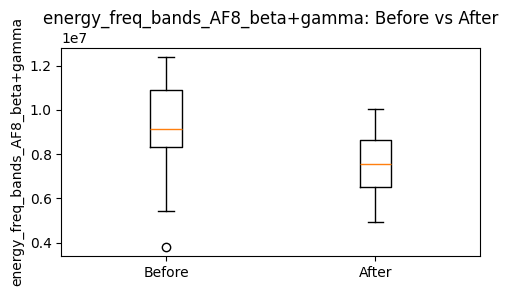

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


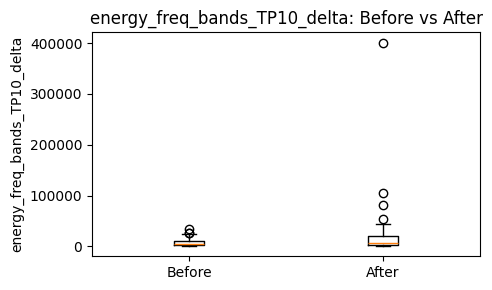

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


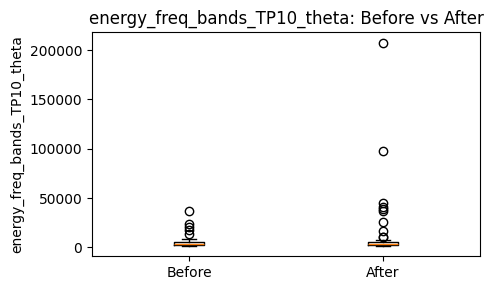

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


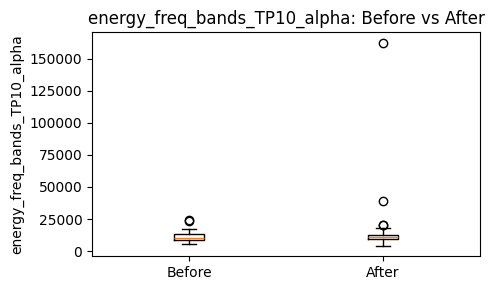

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


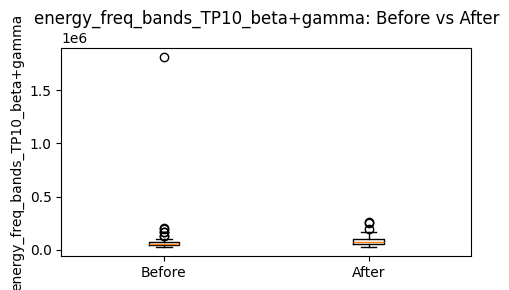

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


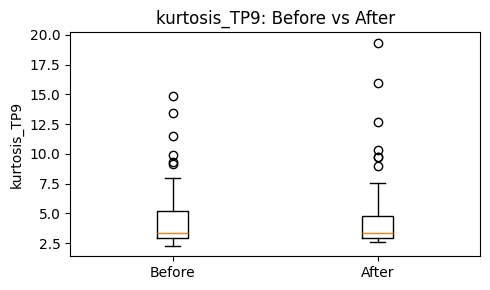

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


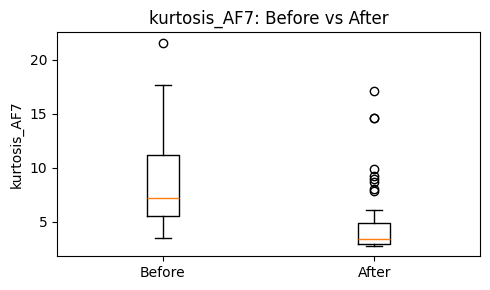

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


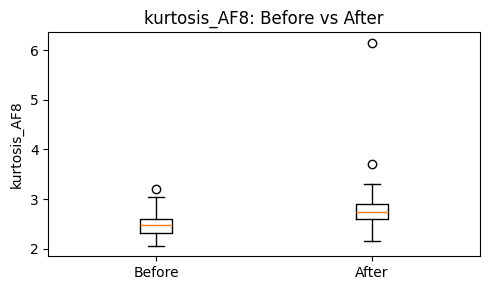

/var/folders/t3/0r69nvms6rvfcd98ncjnt3p40000gn/T/ipykernel_11778/4245752535.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])


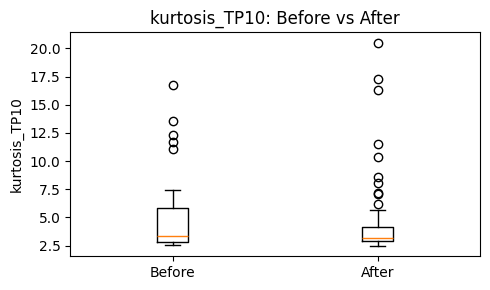

In [36]:
all_feature_columns = features_before.columns.tolist()

for col in all_feature_columns:
    plt.figure(figsize=(5, 3))
    plt.boxplot([features_before[col], features_after[col]], labels=['Before', 'After'])
    plt.ylabel(col)
    plt.title(f'{col}: Before vs After')
    plt.tight_layout()
    plt.show()


# now doing a correlation Matrix

In [37]:
corr_before = features_before.corr()
corr_after = features_after.corr()


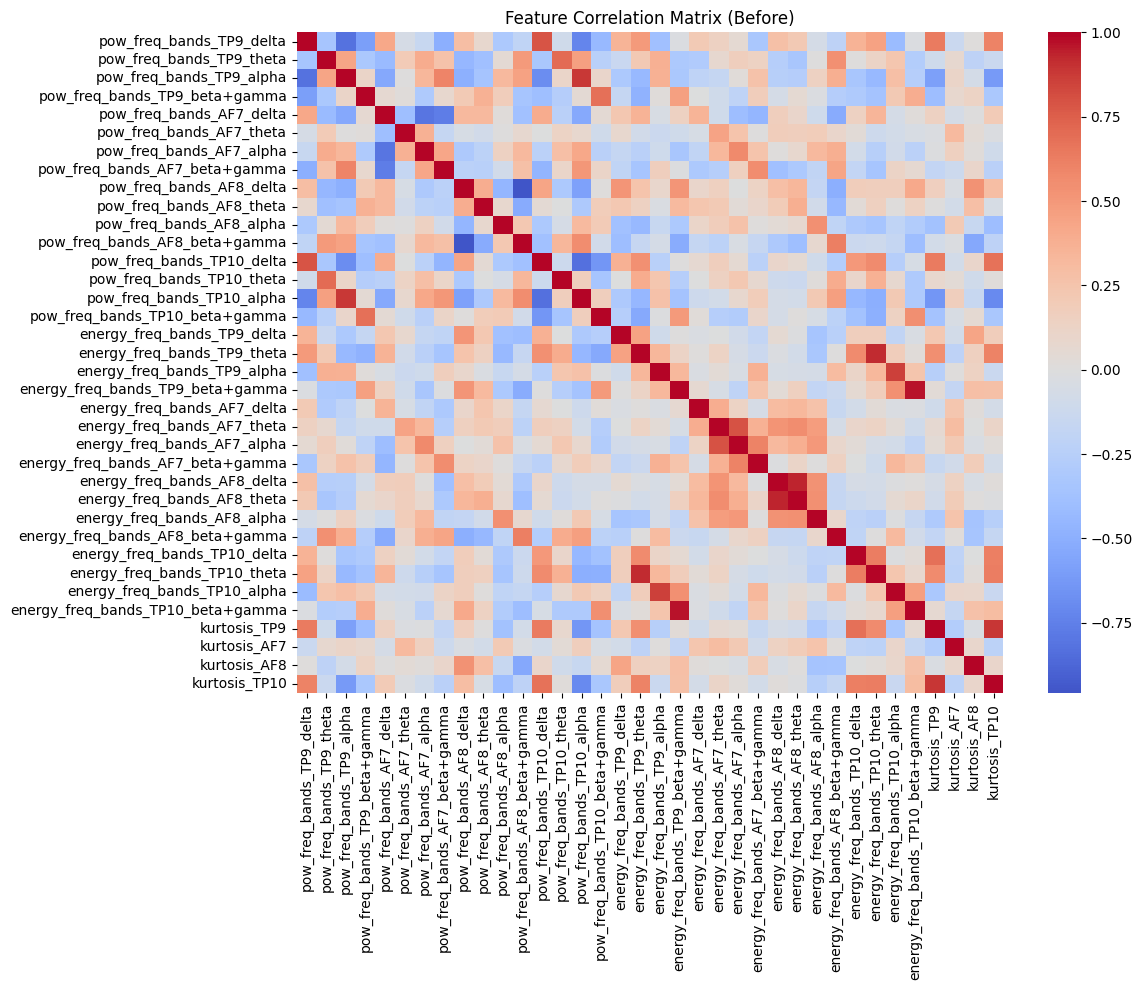

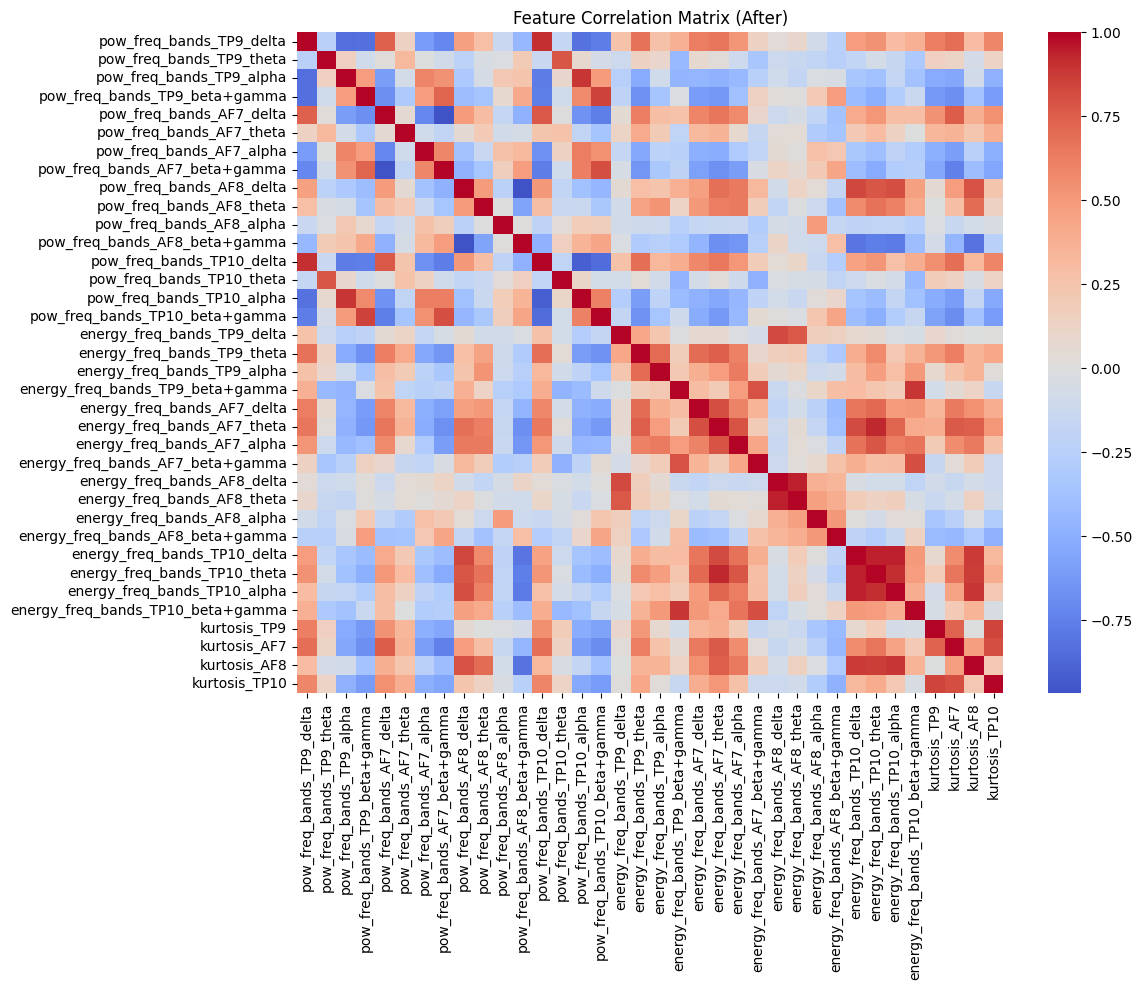

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))
sns.heatmap(corr_before, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title('Feature Correlation Matrix (Before)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(corr_after, cmap='coolwarm', center=0, annot=False, fmt='.2f')
plt.title('Feature Correlation Matrix (After)')
plt.tight_layout()
plt.show()


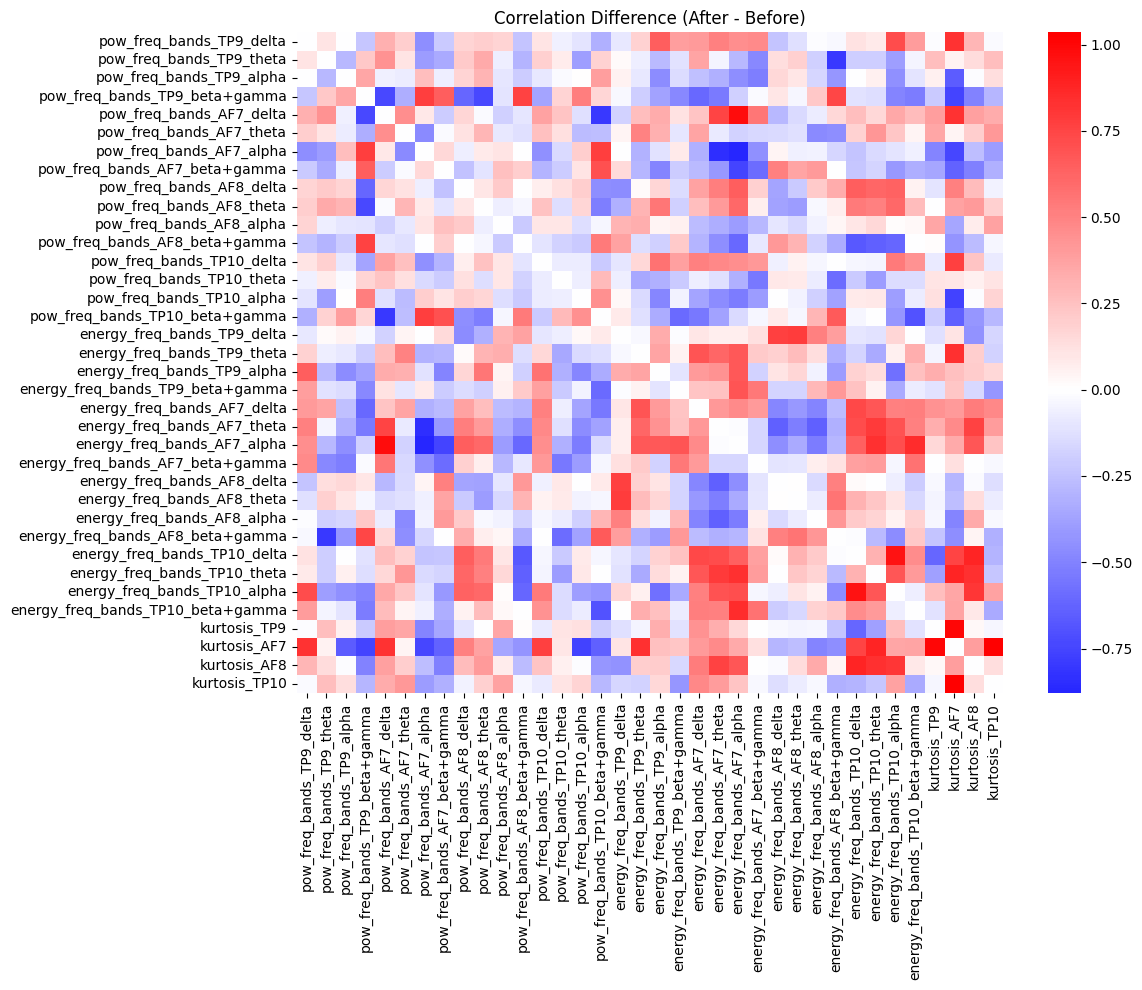

In [39]:
# subtract or plot the difference between the correlation matrices
corr_diff = corr_after - corr_before
plt.figure(figsize=(12,10))
sns.heatmap(corr_diff, cmap='bwr', center=0)
plt.title('Correlation Difference (After - Before)')
plt.tight_layout()
plt.show()


# Clustering

In [40]:
import pandas as pd
import numpy as np

# Combine features from both groups
X = pd.concat([features_before, features_after], ignore_index=True)
group_labels = np.array(['Before'] * len(features_before) + ['After'] * len(features_after))


In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [42]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)


In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)


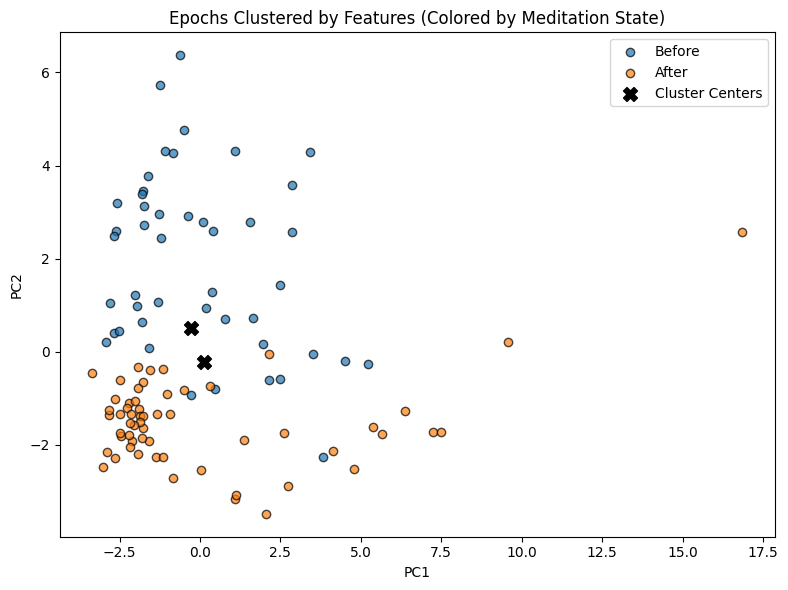

In [44]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Color by true group, not cluster!
colors = ['#1f77b4' if label == 'Before' else '#ff7f0e' for label in group_labels]

plt.figure(figsize=(8,6))
for group, color in zip(['Before', 'After'], ['#1f77b4', '#ff7f0e']):
    mask = group_labels == group
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], c=color, label=group, alpha=0.7, edgecolor='k')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Epochs Clustered by Features (Colored by Meditation State)')
plt.legend()
plt.tight_layout()

# code start to show cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            c='black', s=100, marker='X', label='Cluster Centers')
plt.legend()
# code end to show cluster centers

plt.show()


# Final ... Cohen test

# Final - Cohen Test

In [45]:
import numpy as np
import pandas as pd

def cohens_d(x, y):
    # x: before, y: after
    nx = len(x)
    ny = len(y)
    s1 = np.var(x, ddof=1)
    s2 = np.var(y, ddof=1)
    pooled_std = np.sqrt(((nx - 1)*s1 + (ny - 1)*s2) / (nx + ny - 2))
    d = (np.mean(y) - np.mean(x)) / pooled_std
    return d

# For all features:
cohen_d_results = {}
for col in features_before.columns:
    cohen_d_results[col] = cohens_d(features_before[col], features_after[col])

# Sort by magnitude (largest effect size first)
cohen_d_sorted = pd.Series(cohen_d_results).sort_values(key=np.abs, ascending=False)

print(cohen_d_sorted)


energy_freq_bands_AF7_alpha         -1.918071
energy_freq_bands_AF8_alpha         -1.731006
energy_freq_bands_AF7_beta+gamma    -1.241635
pow_freq_bands_AF7_theta            -1.226036
kurtosis_AF7                        -1.055312
energy_freq_bands_AF8_beta+gamma    -1.035771
pow_freq_bands_AF7_beta+gamma        0.857805
pow_freq_bands_AF8_alpha            -0.854968
pow_freq_bands_AF8_theta            -0.846104
energy_freq_bands_AF8_theta         -0.835689
kurtosis_AF8                         0.780587
pow_freq_bands_AF7_alpha            -0.766945
energy_freq_bands_AF7_theta         -0.681959
pow_freq_bands_AF8_beta+gamma        0.581909
energy_freq_bands_AF8_delta         -0.470972
pow_freq_bands_TP9_theta            -0.386003
pow_freq_bands_TP10_alpha           -0.361132
pow_freq_bands_TP10_delta            0.322350
energy_freq_bands_TP10_delta         0.318865
pow_freq_bands_TP9_alpha            -0.276337
energy_freq_bands_TP10_theta         0.269083
pow_freq_bands_AF8_delta          

In [ ]:
import matplotlib.pyplot as plt

top_n = 10
cohen_d_sorted[:top_n].plot(kind='barh', color='teal')
plt.axvline(0, color='k', linestyle='--')
plt.title(f'Top {top_n} Features by Effect Size (Cohen\'s d)')
plt.xlabel('Cohen\'s d')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
